# Genetic algorithms

These depend on three steps. These are described as mutation, crossover and selection. A basic routine looks like this:

1. At the beginning, the initial population *pop* is randomly generated and evaluated (through its fitness)
2. Then, the best individuals are identified and ranked.
3. The current population is evolved into a new one formed of the *children* of members of the population.
4. A small but random number of alleles (genetic descriptors) are mutated .
5. Return to step 2 until a convergence criteria is fulfilled.

First part: A function that returns a float from a bit string (for future evaluation of a test function)

In [1]:
import numpy as np

#size = 32
#bitlist = np.random.randint(2,size=size)
#max number
#bitlist = np.ones(size, dtype=int)
#min number
#bitlist = np.zeros(size, dtype=int)

#this gives a float between 0 and 1 from the bit list
def bit_to_float(bitlist, domain):
    res=0
    j=-1
    for i in range(0,len(bitlist)):
        x=2**j
        res+=x*bitlist[i]
        j-=1
    return domain[0] + res*(domain[1]-domain[0])

def bit_to_float_array(bit_array, domains):
    values = np.zeros(len(bit_array))
    if len(domains) == 1:
        for i in range(len(bit_array)):
            values[i] = bit_to_float(bit_array[i], domains[0])
    else:
        for i in range(len(bit_array)):
            values[i] = bit_to_float(bit_array[i], domains[i])
    return values


In [3]:
#function to optimize
#see this: https://en.wikipedia.org/wiki/Test_functions_for_optimization
#for some test functions to optimize
def ackley(xvec, a=20, b=0.2, c = 2*np.pi):
    #domain is -5, 5
    d=len(xvec)
    func = -a*np.exp(-b*np.sqrt(sum(xvec**2)/d)) - np.exp(sum(np.cos(c*xvec))/d) + a + np.exp(1)
    return func

def beale(xvec):
    #domain is -5, 5
    x= xvec[0]
    y = xvec[1]
    func = (1.5 -x + x*y)**2 + (2.25 - x + x*y**2)**2 + (2.625 - x + x*y**3)**2
    return func

def evaluate_function(population):
    evals = np.zeros(len(population))
    for p in range(len(population)):
        #evals[p] = ackley(bit_to_float_array(population[p], [[-5,5]]))
        evals[p] = beale(bit_to_float_array(population[p], [[-4.5,4.5]]))
    return evals

def children_from_parents_and_mutate(pair_parents, mutation_rate, breed_method = "splicing"):
    parent_1 = np.concatenate(pair_parents[0])
    parent_2 = np.concatenate(pair_parents[1])
    child = parent_1

    #how many dimensions:
    dim = len(pair_parents[0])
    N = len(pair_parents[0][0])

    if breed_method == "dna":
        for j in range(len(child)):
            randn = np.random.rand()
            if randn < (1-mutation_rate)/2:
                child[j] = parent_2[j]
            elif (1-mutation_rate) <= randn:
                child[j] = np.random.randint(2)
    elif breed_method == "splicing":
        for ds in range(dim):
            splice_point = np.random.randint(N)
            child[(splice_point+ds*N):(ds*N + N)] = parent_2[(splice_point+ds*N):(ds*N + N)]
        for j in range(len(child)):
            randn = np.random.rand()
            if randn < mutation_rate:
                child[j] = (1 - child[j])

    export_child = np.array_split(child,dim)
    return export_child

#create other breeding where a block of genes (from index I to M) is taken from each parent


def new_population(population, fidelity, N_elite, mutation_rate):
    #fidelity
    scaled_fidelity = (np.max(fidelity) - fidelity)/(np.max(fidelity) - np.min(fidelity))
    #sort them
    sorted_fidelity = np.argsort(scaled_fidelity)[::-1] #this gives you the indices of the lowest fidelity to the highest - we are trying to minimize F
    #make scaled fidelity into a probability distribution
    prob_fidelity = scaled_fidelity/np.sum(scaled_fidelity)
    #choose a member for crossover, based on fitness
    #np.random.choice(np.arange(0,len(population),1, dtype=int), p=prob_fidelity)

    #number of elites is N_elite
    new_population = population
    #keep some of the fittest individuals
    dim = len(population[0])
    new_population[0] = population[sorted_fidelity[0]]
    for i in range(1, N_elite):
        init_indiv = np.concatenate(population[sorted_fidelity[i]])
        for j in range(len(init_indiv)):
            randn = np.random.rand()
            if randn < mutation_rate:
                init_indiv[j] = (1 - init_indiv[j])
        new_population[i] = np.array_split(init_indiv,dim)
        
    #create children and mutations on the other individuals
    for i in range(N_elite, len(population)):
        #create children
        cond = True
        while cond:
            selected = np.random.choice(N,2,p=prob_fidelity)
            if selected[0] != selected[1]: #parents need to be different!
                cond = False
            else:
                cond = True

        if scaled_fidelity[selected[0]] < scaled_fidelity[selected[1]]:
            pair = [population[selected[0]], population[selected[1]]]
        else:
            pair = [population[selected[1]], population[selected[0]]]
        #breed the pair and introduce some mutation
        population[i] = children_from_parents_and_mutate(pair, mutation_rate)

    return population


In [6]:
#population of N individuals
from numpy import linalg as LA
N=20
nbit = 32
size = (2,nbit) #16 bit precision for each number, 2 dimensional problem
population = [np.random.randint(2,size=size) for j in range(N)]
fidelity = evaluate_function(population)
min_mutation_rate = 0.05  #5 percent allele mutation
max_mutation_rate = 0.1
N_elite = 4
#function is beale
#domain:
domain = [-4.5,4.5]
it_spread = 20

iteration = 0
maxiter = 500
kept_fidelity = np.zeros((maxiter, N))
away_from_real_minima = np.zeros((maxiter,N))
real_minimum = np.array([3,0.5])
keep_mutation_rate = np.zeros(maxiter)
keep_var_factor = np.zeros(maxiter)

while iteration < maxiter:
    updated_mutation_rate = min_mutation_rate
    #var_factor = 0
    #if iteration > it_spread:
    #    var_factor = kept_fidelity[iteration -1][0]/(np.mean([kept_fidelity[iteration -1 - j][0] for j in range(it_spread)]))
    #updated_mutation_rate += var_factor*(max_mutation_rate - min_mutation_rate)
    #keep_mutation_rate[iteration] = updated_mutation_rate
    #keep_var_factor[iteration] = var_factor
    population = new_population(population, fidelity, N_elite, updated_mutation_rate)
    fidelity = evaluate_function(population)
    kept_fidelity[iteration] = np.sort(fidelity)
    print("iteration {}, best fidelity = {}".format(iteration,np.min(fidelity)))
    for i in range(N):
        site = bit_to_float_array(population[i], [domain])
        away_from_real_minima[iteration, i] = LA.norm(site - real_minimum)

    iteration += 1


iteration 0, best fidelity = 2.6504041300197967
iteration 1, best fidelity = 2.057126236214282
iteration 2, best fidelity = 2.057126236214282
iteration 3, best fidelity = 2.057126236214282
iteration 4, best fidelity = 1.2795997977660774
iteration 5, best fidelity = 1.2795997977660774
iteration 6, best fidelity = 1.2795997977660774
iteration 7, best fidelity = 1.2795997977660774
iteration 8, best fidelity = 1.2795997977660774
iteration 9, best fidelity = 1.2795997977660774
iteration 10, best fidelity = 1.2795997977660774
iteration 11, best fidelity = 1.2795997977660774
iteration 12, best fidelity = 0.843845427697292
iteration 13, best fidelity = 0.843845427697292
iteration 14, best fidelity = 0.843845427697292
iteration 15, best fidelity = 0.843845427697292
iteration 16, best fidelity = 0.843845427697292
iteration 17, best fidelity = 0.843845427697292
iteration 18, best fidelity = 0.843845427697292
iteration 19, best fidelity = 0.843845427697292
iteration 20, best fidelity = 0.843845427

In [185]:
print('and the best individual is...')
best_individual = population[np.argsort(kept_fidelity[-1])[0]]
best_vec = bit_to_float_array(best_individual, [domain])
print('(x,y,...) = {} '.format(best_vec))
print('with a f(X) = {} [real min is {}]'.format(beale(best_vec), 0))

and the best individual is...
(x,y,...) = [2.95426784 0.48646942] 
with a f(X) = 0.00043649580264643365 [real min is 0]


Plotting the progress of the fidelity to 0 and the absolute minima

NameError: name 'mutation_rate' is not defined

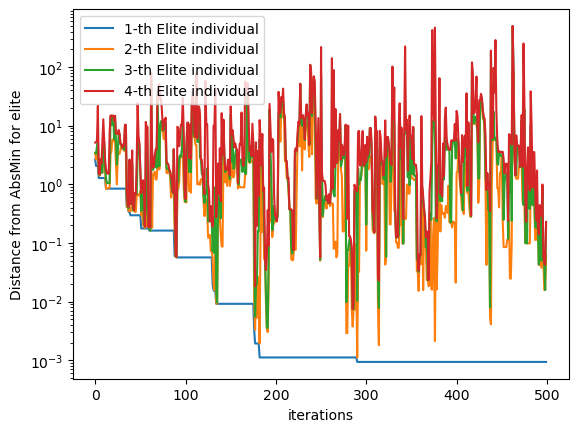

In [7]:
from matplotlib import pyplot as plt
x = [i for i in range(maxiter)]
nshow = 4
y = np.zeros((nshow, maxiter))
for k in range(nshow):
    for j in range(maxiter):
        #y[k,j] = away_from_real_minima[j,k]
        y[k,j] = kept_fidelity[j,k]
    plt.plot(x,y[k,:], label = '{}-th Elite individual'.format(k+1))
plt.yscale('log')
#plt.ylim([10**(-18),10])
plt.xlabel('iterations')
plt.legend()
plt.ylabel('Distance from AbsMin for elite')
plt.title('Pop = {}, N_bit = {}, mutation = {}, N_elite = {}'.format(N,nbit,mutation_rate, N_elite));

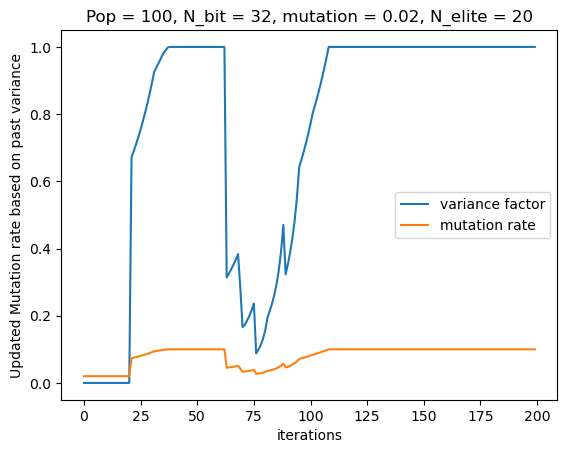

In [265]:
x = [i for i in range(maxiter)]
plt.plot(x,keep_var_factor, label = 'variance factor')
plt.plot(x,keep_mutation_rate, label = 'mutation rate')
plt.legend()
#plt.yscale('log')
#plt.ylim([10**(-18),10])
plt.xlabel('iterations')
plt.legend()
plt.ylabel('Updated Mutation rate based on past variance')
plt.title('Pop = {}, N_bit = {}, mutation = {}, N_elite = {}'.format(N,nbit,mutation_rate, N_elite));